# Website Languages A/B Test

This notebook details the approaches and the conclusions of how I approached verifying the results of an A/B Test. The test measured conversion rates when a website used custom language tamplates for spanish speaking countries compared to the same template (a Spain dialect translation) for all countries. We would think that custom templates would do better but that was not the case, the results point to the same template increasing conversions. So in this notebook I seek to see if the test can be trusted and if not what could be done differently for the next test. 

<b>This notebook covers:</b>
1. Data Cleaning
2. Verifying Results 
3. Using Statistical Tools to test for Sample Bias


<b>Conclusions:</b>
1. If the results seem unbelievable, they probably are. We intuitively know that a custom website for each region would yield better results. So when it didn't it's important to take extra precautions to make sure that the test was run appropriately, in this case we found that the test sample wasn't indicative of the population
2. The test was misleading because suffered from sample bias and a possible small sample size which needs to be addressed.

<b>Recommendations:</b>
1. Let the test run for a longer time, the test only ran for 5 days and the results seem to be trending the in expected direction.
2. Create a model like the decision tree used here to automate a/b test validation.
3. Run multiple test so that we can refine the reasons why this sample might have been biased.

### Aside from that, I hope you enjoy this notebook!

# <u> 1. Loading Dependencies

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [36]:
# Make all my plots 538 Style
plt.style.use('fivethirtyeight')

# <u> 2. Retrieving Data

In [3]:
# User Data
user = pd.read_csv('user_table.csv')
# Online Data
test = pd.read_csv('test_table.csv', parse_dates= ['date'])

In [4]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [5]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


# <u>3. Cleaning Data

<b>Steps:</b>
1. Join the Tables on the common column user_id
2. Check for Null Values
3. Deal with Null Values

<b> 1. Join Data

In [6]:
df = pd.merge(user, test, on = 'user_id', how = 'outer')
print 'The table has %r rows and %r columns'%df.shape

The table has 453321 rows and 12 columns


<b> 2. Check for Null Values

In [7]:
np.sum(df.isnull())

user_id                  0
sex                    454
age                    454
country                454
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
dtype: int64

<u>Take aways: </u><br>
a. There are null values in 3 columns: sex, age, country, and ads channel<br>
b. We will delete the rows with null values for sex, age and country because it's so few.<br>
c. Since there are so many missing values for ads_channel we will fill create a different colum that raises a 1 when it's a null value and a 0 when it's not. <br>
d. We will investigate the ads_channel to determine whether to erase it or not.<br>

<b> 3. Dealing with Null Values

<u><i>a. Erase Null Values</u></i>

We will erase the null values 

In [8]:
df[df.sex.isnull()].head()

,user_id,sex,age,country,date,source,device,browser_language,ads_channel,browser,conversion,test
452867,657841,NaN,NaN,NaN,2015-12-02,Ads,Mobile,ES,Bing,Android_App,0,0
452868,859340,NaN,NaN,NaN,2015-12-04,Direct,Mobile,EN,NaN,Android_App,0,0
452869,716487,NaN,NaN,NaN,2015-12-04,SEO,Mobile,ES,NaN,Android_App,0,0
452870,87209,NaN,NaN,NaN,2015-12-01,Direct,Web,ES,NaN,Chrome,0,0
452871,771642,NaN,NaN,NaN,2015-11-30,SEO,Mobile,ES,NaN,Android_App,0,0


The missing values for sex,age, and country are all the same 454 rows so we will get rid of them

In [9]:
df = df.iloc[df.index.difference(df[df.sex.isnull()].index)]

<u><i> b. Create a New Column that indicates missing values for ads_channel 

In [16]:
df['ads_channel_is_null'] = [1 if i == True else 0 for i in df.ads_channel.isnull()]

# <u> 4. Verify Conclusion

We will first verify the conclusion that a single translation did indeed out perform the custom template

1. We will first see if the samples are evenly distributed.
2. Then we will see how they performed overall
3. Then we will see how they did overtime.

<b>1. Distribution of Test and Control

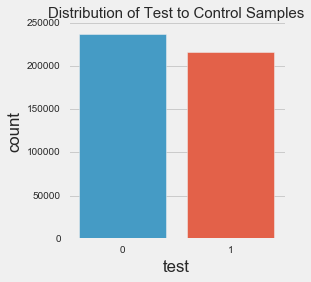

In [14]:
_ = sns.factorplot('test', data = df, kind = 'count')
plt.title('Distribution of Test to Control Samples', size = 15)

It's about the same, so there is no large skewness.

<b> 2. How they Performed Overall</b>

<u>Steps:</u>
1. We will ignore spain because the translations didn't change for them
2. We will see what were the conversions for the test and the control

In [19]:
# Ignoring Spain
data = df[df.country != 'Spain']

test_data = data[data.test == 1].conversion
control_data = data[data.test == 0].conversion

print 'Results for the test %r'%(test_data.sum()/float(test_data.count()))
print 'Results for the control %r'%(control_data.sum()/float(control_data.count()))

Results for the test 0.043411161678422794
Results for the control 0.048291790557495239


There <b>IS</b> a jump for the same template!

<b>3. Comparing it Over Time</b>

<u>Steps:</u>
a. We will get a ratio of test conversion vs control for each day.
b. Plot it over time.

In [25]:
# a. Get the ratio
ratio = df[(df.test == 1) & (df.country != 'Spain')].groupby('date').mean()['conversion']/df[(df.test == 0)& (df.country != 'Spain')].groupby('date').mean()['conversion']

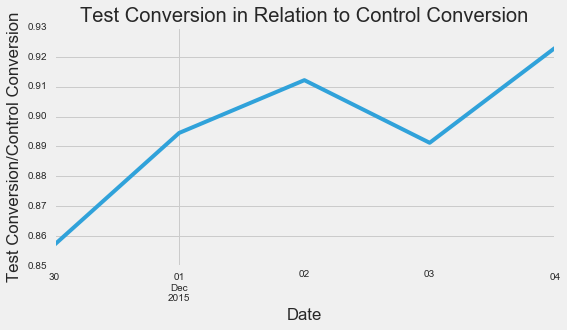

In [27]:
# b. Plot it Over Time
_ = (ratio).plot()
_.figure.set_size_inches(8,4)
plt.title('Test Conversion in Relation to Control Conversion')
plt.xlabel('Date')
_ = plt.ylabel('Test Conversion/Control Conversion')

<b> Takeaways:</b>
1. The Control sample consistently under-performs throughout the 5 days
2. It is trending upward which could be a sign that the a/b test was for too short a time span

# <u> 5. Testing for Statistical Significance

To prove if the test was valid we can check for two things:<br>
    a. Small Sample Size<br>
    b. Sample Bias<br>

<u> Small Sample Size</u>
We already saw that the test ran for 5 days in which the test sample was beginning to trend upwards, so that could be the culprit. However, we cannot know so we can look to bias get a further understanding.

<u>Sample Bias</u>
For the a/b test to be valid, both the control and test sample have to be the same except for the one feature. If they are not then the effect of another feature could of caused the change in conversion. <br>
<b>So here we will use three tools:</b>
1. We will plot the distributions of each feature in for the test and control
2. We will use a decision tree to see if any feature can predict whether a data point is in a test or control (it shouldn't!)
3. We will use a t-test to verify results

### 1. Distribution of Columns in Relation to Test or Control Sample

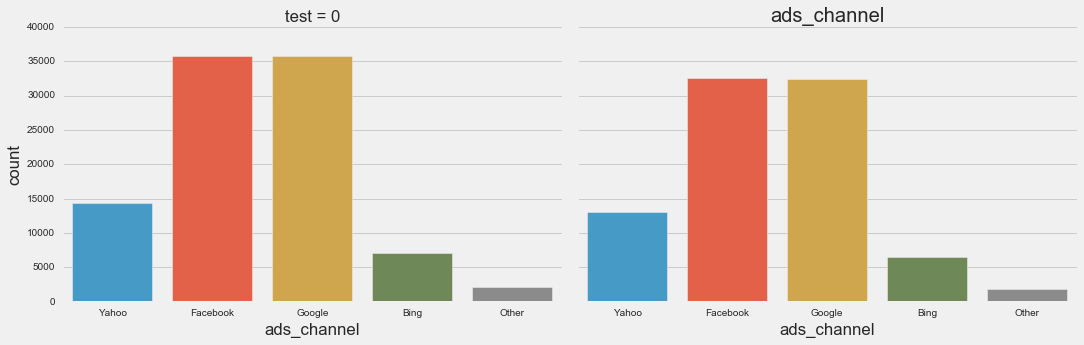

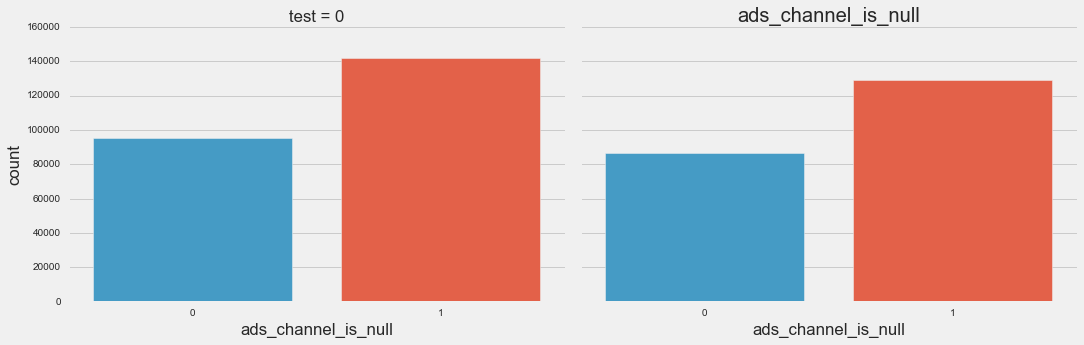

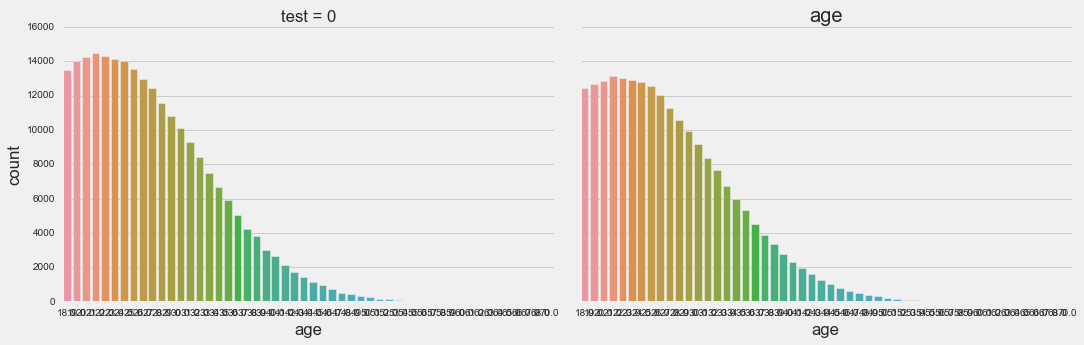

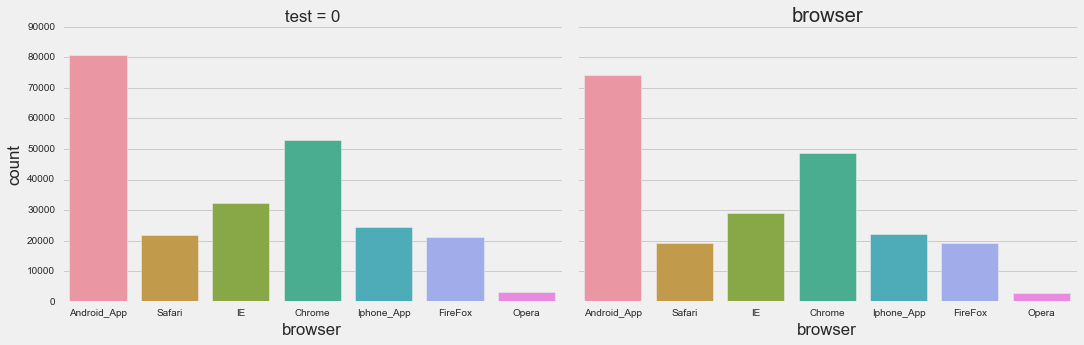

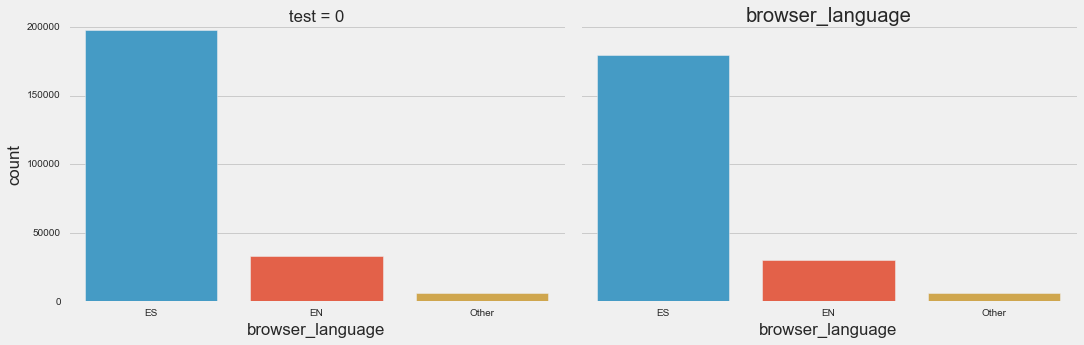

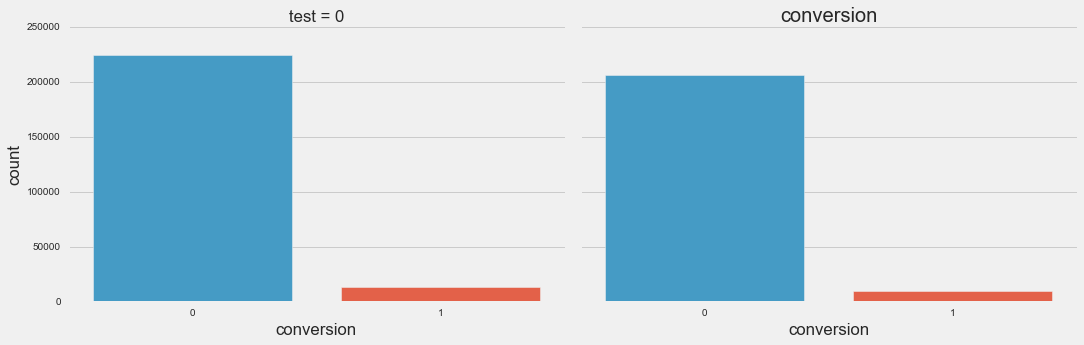

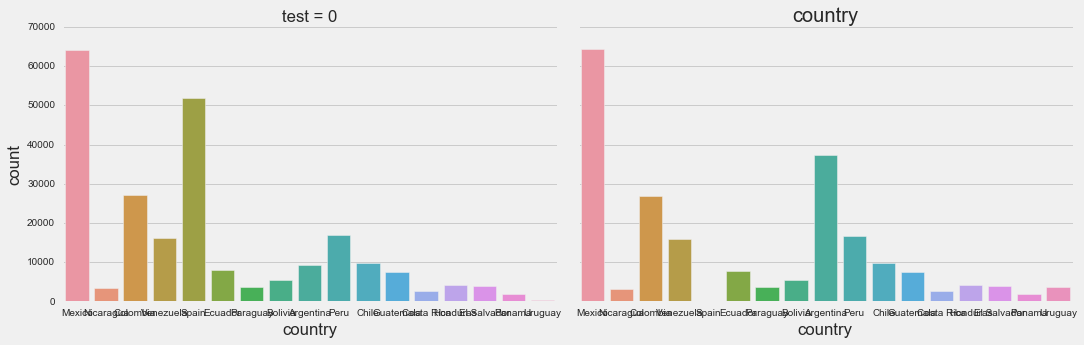

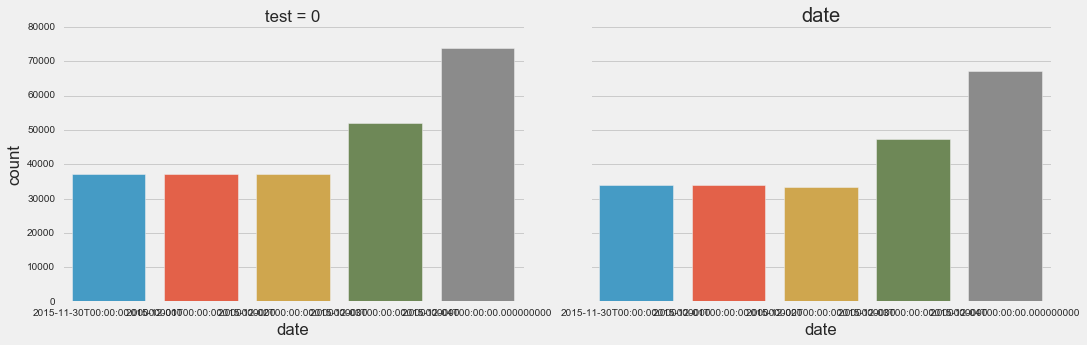

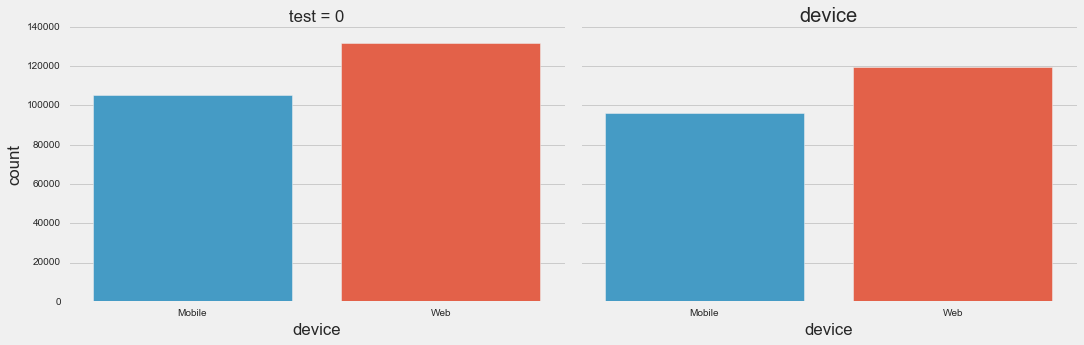

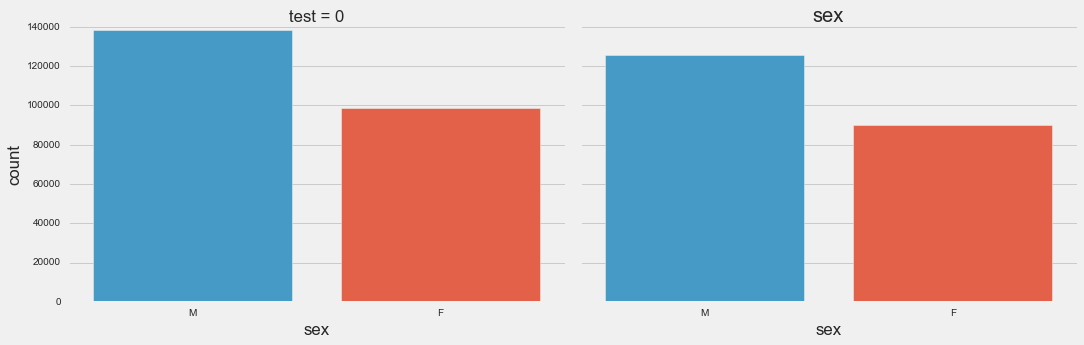

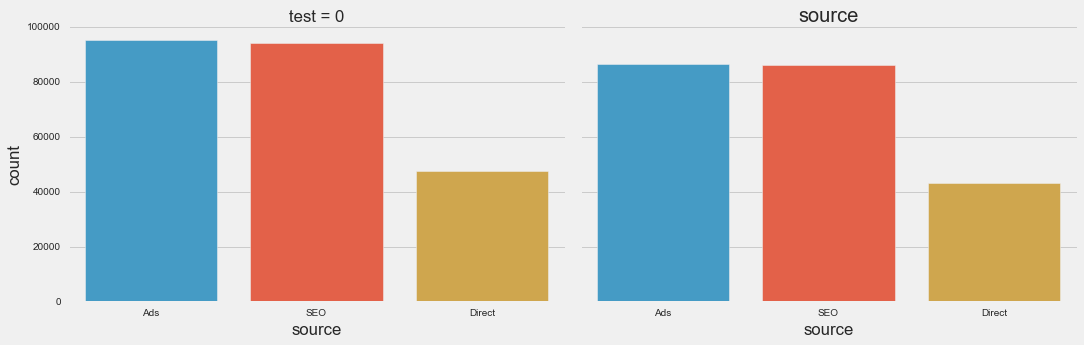

In [15]:
# Let's look at each feature's conversion in relation
#to whether it's a test or control sample
for i in df.columns.difference(['user_id', 'test']):
    sns.factorplot(i, data = df, kind = 'count', col = 'test', size = 5, aspect = 1.5)
    plt.title(i)

<b> Takeaways:</b>
1. There is no clear difference between the control and test sample for each features
2. There seem to make small differences between age and countries but it's not definite.
3. The new feature we made for the null values seems to have no effect.

### 2. Training a Model To Test for Bias

Here we will use a random forrest classifier to see if any features become significant in predicting whether a data point is in a test or control sample. We will make the test column the dependent variable and the rest of the features <u>except</u> conversion as independent variables. 

<b>This process can be fully automated in the future and give a warning when an a/b test may contain sample bias!</b>



<u><i>NOTE: The performance of the model is not important as long as it can give some predictive power at all! Since if it can be preditive at all then that would mean that the sample is biased


In [29]:
# Create a New Dataframe without the conversion column
tree_df = df[df.columns.difference(['conversion'])].copy()

In [31]:
# Create dummy variables for categorical values
ads_channel_dums = pd.get_dummies(tree_df.ads_channel, prefix= 'ads')
browser_dums = pd.get_dummies(tree_df.browser,prefix= 'browser')
browser_language_dums = pd.get_dummies(tree_df.browser_language,prefix= 'browser_language')
country_dums = pd.get_dummies(tree_df.country,prefix= 'country')
device_dums = pd.get_dummies(tree_df.device,prefix= 'device')
sex_dums = pd.get_dummies(tree_df.sex,prefix= 'sex')
source_dums = pd.get_dummies(tree_df.source,prefix= 'source')

dums_list = [ads_channel_dums, browser_dums,browser_language_dums,country_dums,device_dums,sex_dums,source_dums ]

<i>Training the Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier

X = tree_df[['age']].join(dums_list)
y = tree_df['test']
tree = DecisionTreeClassifier()
tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

<i>Plotting

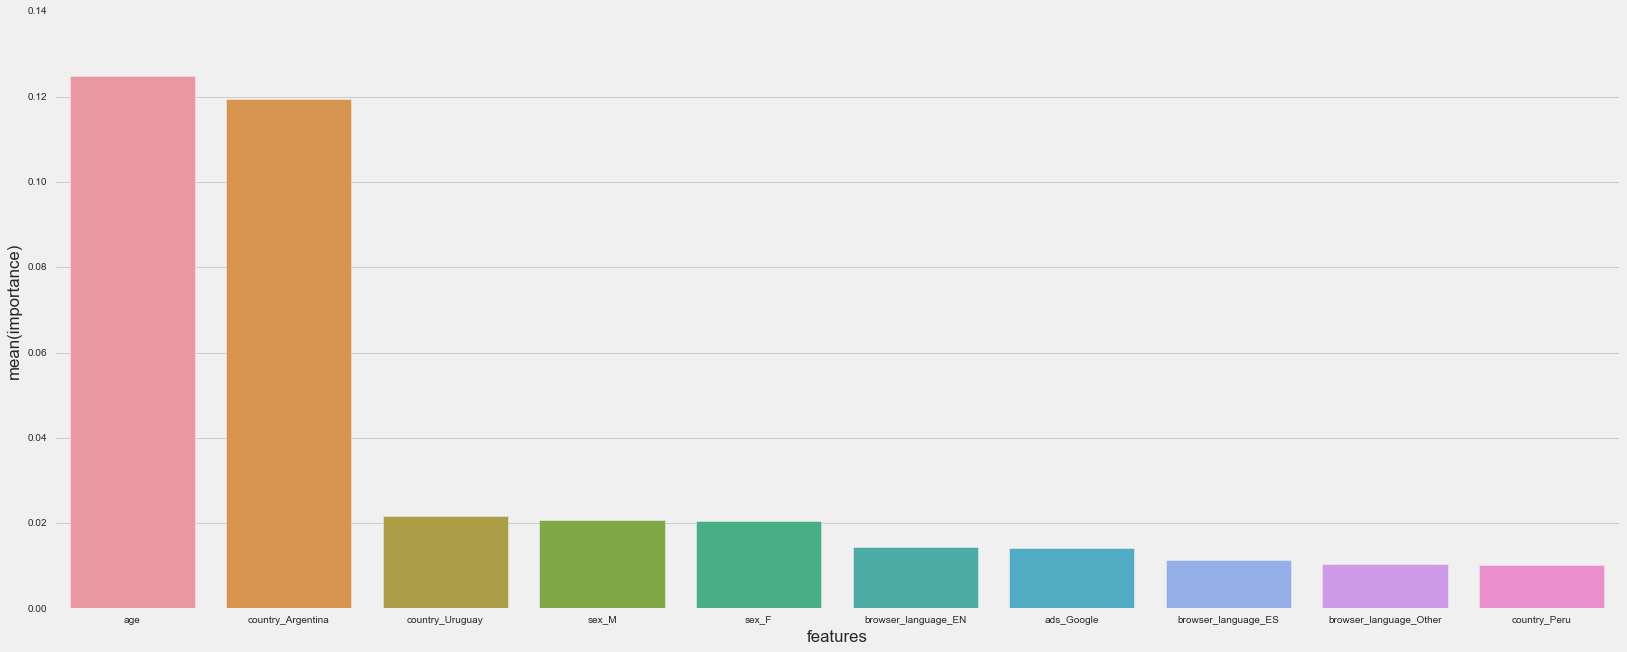

In [33]:
features_significance = pd.DataFrame({'features': X.columns,\
          'importance': tree.feature_importances_}).sort_values('importance', ascending = False).iloc[1:11]
_ = sns.barplot(x = 'features', y = 'importance'
                  ,data = features_significance, orient = 'v')
_.figure.set_size_inches(25,10)

<b> Takeaways:</b>
1. There are two very predictive features: Age and whether the country is Argentina
2. This is a signal for bias so we can verify with T-tests

### 3. Using T-Tests to Verify Results

<b>Approach:</b>
1. We will then verify the power of these features by running t-tests on age, country, and a feature that isn't predictive which is conversion source. 
2. We will conclude that there is bias in the data if the data comes back non-significant for the first two features and significant for the last one!

<b>1. Running T-Test

<i><b><u> Countries

In [181]:
country = []
conversion_test = []
conversion_control = []
p_vals = []
for i in data.country.value_counts().index:
    temp = data[data.country == i]
    cat1 = temp[data.test == 1].conversion
    cat2 = temp[data.test == 0].conversion
    ttest, p =stats.ttest_ind(cat2, cat1)
    country.append(i)
    conversion_test.append(cat1.sum()/float(len(cat1)))
    conversion_control.append(cat2.sum()/float(len(cat2)))

    ttest_vals.append(ttest)
    p_vals.append(p)
    
pd.DataFrame({'country': country, 
              'conversion_test': conversion_test,
              'conversion_control': conversion_control,
             'p_value': p_vals})\
[['country', 'p_value', 'conversion_test', 'conversion_control']]

/Users/Fernanhid/miniconda/envs/datasci27/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/Fernanhid/miniconda/envs/datasci27/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,country,p_value,conversion_test,conversion_control
0,Mexico,0.165547,0.051186,0.049495
1,Colombia,0.423733,0.050571,0.052089
2,Argentina,0.321766,0.013725,0.015071
3,Peru,0.771950,0.050604,0.049914
4,Venezuela,0.573740,0.048978,0.050344
5,Chile,0.302871,0.051295,0.048107
6,Ecuador,0.961512,0.048988,0.049154
7,Guatemala,0.572165,0.048647,0.050643
8,Bolivia,0.718877,0.047901,0.049369
9,Honduras,0.471721,0.047540,0.050906


<b>Takeaway:</b><br>
These p-values in indicate that that we cannot conclude that the difference in dialects had any effect on
conversion</b>

<i><b><u> Age

In [175]:
# They are Very Different!!
from scipy import stats
import numpy as np

t_test_df = data[['age', 'test']].dropna()
cat1 = t_test_df[t_test_df.test == 1].age
cat2 = t_test_df[t_test_df.test == 0].age

ttest, p =stats.ttest_ind(cat1, cat2)
print 't-test independent', ttest
print p

t-test independent -1.30262768871
0.192702647982


<b>Takeaway:</b><br>
We get the same thing when we deal with age, not significant!


<i><b><u> Conversion Source

In [177]:
source = []
conversion_test = []
conversion_control = []
p_vals = []
for i in data.source.value_counts().index:
    temp = data[data.source == i]
    cat1 = temp[data.test == 1].conversion
    cat2 = temp[data.test == 0].conversion
    ttest, p =stats.ttest_ind(cat1, cat2)
    source.append(i)
    conversion_test.append(cat1.sum()/float(len(cat1)))
    conversion_control.append(cat2.sum()/float(len(cat2)))

    ttest_vals.append(ttest)
    p_vals.append(p)
    
pd.DataFrame({'source': source, 
              'conversion_test': conversion_test,
              'conversion_control': conversion_control,
             'p_value': p_vals})\
[['source', 'p_value', 'conversion_test', 'conversion_control']]

/Users/Fernanhid/miniconda/envs/datasci27/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/Fernanhid/miniconda/envs/datasci27/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,source,p_value,conversion_test,conversion_control
0,Ads,6.488992e-07,0.043546,0.048754
1,SEO,4.565763e-04,0.043770,0.047430
2,Direct,4.382345e-06,0.042489,0.049267


<b>Takeaway:</b><br>
The test becomes significant when we use a feature that was not preditive in the decision tree model.

<b>2. Determination:</b> <br>
The A/B test suffers from sample bias and possibly from a small sample size. When using a decision tree model and t-test they point to age and countries sample as a source of bias.

# Conclusion

### <b> Three take aways that we can take from this: </b>

<b>1. If the Results Seem Unbelievable, They Probably Are</b> <br>
We intuitively know that a custom website for each region would yield better results.
So when it didn't it's important to take extra precautions to make sure that the test was run appropriately,
in this case we found that the test sample wasn't indicative of the population<br>
<b>2. We can Automate This Process Using Machine Learning</b> <br>
By building a model that can show us if any features can predict whether a user is in the test or control sample, we can automate the process. We can set a threshold for feature significance and let the model tell us automatically if the sample is biased or not! This gives us more time to deal with deeper subjects.
<b>3. By simply looking at feature distributions, we miss the subtly of sample bias</b> <br>
When we saw the distribution of features, all the features seemed balanced. There were a little discrepancies in country but aged seemed balanced. If we had not run T-test or the decision tree to prove statistical significance then we would of missed age as the major indicator of a biased data set. When running an A/B test, the quality of the test is just important if not more important than the results. 

<b>There are many ways to test bias but I'm going to try 2 here:<br></b>
a. Train a <u>Model</u> to see if it can predict whether it's the test or control sample<br>
(if the sample is unbiased then no features should be predictive)<br>
b. <u>T-test</u>: A t-test should reveal whether a feature's effect on conversion is statistically significant